In [1]:
# import TensorFlow as TF
import pandas as pd
import math
import matplotlib.pylab as plt
import numpy as np
import statistics
from statistics import mean, median
from datetime import datetime
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer # used for handling missing data
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer # used for handling missing data




In [2]:
# importing the data
df = pd.read_csv('data.csv')
data_top = df.head()
copy = df.copy() 


# func: creates dictionary with a certain column value as keys and their corresponding data as values in a dataframe
# params: the column name which will be the keys in the dictionary and the dataframe which will be transformed
# returns: the resulting dictionary
def create_dict(target_var, df): 
    org_ids = list(df[target_var]) 
    list_set = set(org_ids) # get unique elements
    unique = list(list_set) # place them in a list 
    df = df.groupby([target_var]) # group the data in the dataframe by the key value
    
    dictionary = {} 
    for item in unique:
        df_id = df.get_group(item) # create a dataframe from the data corresponding to a key value
        # sort the data in each single dataframe on date
        df_id["StatementDetails.FinancialPeriodEndDate"] = pd.to_datetime(df_id["StatementDetails.FinancialPeriodEndDate"])
        df_id = df_id.sort_values(by="StatementDetails.FinancialPeriodEndDate")
        dictionary[item] = df_id # add the dataframes to a dictionary
    
    return dictionary


In [3]:
# func: cleans missing values in a dataframe
# params: the dataframe that needs cleaning, and the column name in the dataframe that needs cleaning
# returns: the cleaned dataframe
def df_clean(df, column_name):
    df = df.reset_index(drop=True)
    
    for i in range(1, len(df[column_name])-2):
        if math.isnan(df.at[i, column_name]):
            if not math.isnan(df.at[i-1, column_name]):
                if not math.isnan(df.at[i+1, column_name]):
                    mean = (df.at[i+1, column_name] + df.at[i-1, column_name])/2
                    df.at[i, column_name] = mean
    df = df[df[column_name].notna()]
    return df



# func: cleans missing values in a dictionary
# params: the dictionary that needs cleaning,  and the column name in the dataframe that needs cleaning
# returns: the cleaned dictionary
def dict_clean_final(dictionary, column_name):
    dict_clean = {}
    for key in dictionary:
        dict_clean[key] = df_clean(dictionary[key], column_name)
    return dict_clean


In [4]:
# func: removes outliers of a dictionary
# params: a dictionary whose outliers need to be removed, the column of the dataframe which outliers need to be removed
# returns: the dictionary without outliers
def manage_outliers(dictionary, column_name):
    dictionary_out = {}
    for key in dictionary:
        df = dictionary[key]
        if len(df) > 2:
            df = df.reset_index(drop=True)
            x_hat = df[column_name].mean()
            stddv = statistics.stdev(df[column_name])
            for i in range(len(df[column_name])-1):
                x = df.at[i, column_name]
                d_x = (abs(x - x_hat))/stddv
                if d_x > 3:
                    df = df.drop(i)
        
        dictionary_out[key] = df
    return dictionary_out

# func: removes outliers of a dataframe
# params: a dataframe whose outliers need to be removed, the column of the dataframe which outliers need to be removed
# returns: the dataframe without outliers
def manage_outliers_df(df, column_name, d_max=3):
    df = df.reset_index(drop=True)    
    for i in range(len(df[column_name])-1):
        x = df.at[i, column_name]
        x_hat = df[column_name].mean()
        stddv = statistics.stdev(df[column_name])
        d_x = (abs(x - x_hat))/stddv
        if d_x > d_max:
            df.drop(i)
    return df
    
# func: adds column to df which contains the scaled Emissions based on sector
# params: a dataframe to which a column is added
# returns: the dataframe with the added column
def scale_emissions(df):
    df['CO2toRevenue'] = df['EmissionDataPoints.CO2EquivalentsEmissionDirectScope1']*(df['EmissionIndicators.TotalCO2EquivalentsEmissionsToRevenues']/df['EmissionDataPoints.CO2EquivalentsEmissionTotal'])
    return df

# func: determines if you want to use sector or org_id
# params: the organization id for which you want to determine wether to use sector or org data, the dataframe with the org_id data, and the threshold of minimum datapoints (default = 10)
# returns: true if you need to use the organization data, false if you need to use sector data for predictions
def sector_or_orgid(orgid, df, threshold = 10):
    return len(df[df['organization_id']==orgid]) >= threshold


In [5]:
copy2 = copy[copy['EmissionDataPoints.CO2EquivalentsEmissionDirectScope1'].notna()] # drop all rows with NaN in target column

# make a copy of the original data, so we don't delete original data
copy3 = df.copy()
# create a dictionary with organization ids as keys and their corresponding data in a dataframe as values
# clean the Nan values and outliers in this dictionary
dict_id2 = create_dict('organization_id', copy3)
dict_id2 = dict_clean_final(dict_id2, 'EmissionDataPoints.CO2EquivalentsEmissionDirectScope1')
dict_id2 = dict_clean_final(dict_id2, 'StatementDetails.FinancialPeriodFiscalYear')
dict_id2 = manage_outliers(dict_id2, 'EmissionDataPoints.CO2EquivalentsEmissionDirectScope1')

# create a dictionary with sectors as keys and their corresponding data in a dataframe as values
# clean the Nan values and outliers in this dictionary
sector_dict = create_dict('GTAP sector', copy)
sector_dict = manage_outliers(sector_dict, 'EmissionDataPoints.CO2EquivalentsEmissionDirectScope1')

# add a scaled emissions column to the sector dictionary, that will be used as a new target column
for sector in sector_dict: 
        df_sector = scale_emissions(sector_dict[sector])
        df_sector = df_clean(df_sector, 'CO2toRevenue')
        df_sector = manage_outliers_df(df_sector, 'CO2toRevenue')
        sector_dict[sector] = df_sector

/var/folders/xr/5n5p0p5d4zjg8f57zwt16lyr0000gn/T/ipykernel_51289/382062376.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_id["StatementDetails.FinancialPeriodEndDate"] = pd.to_datetime(df_id["StatementDetails.FinancialPeriodEndDate"])
/var/folders/xr/5n5p0p5d4zjg8f57zwt16lyr0000gn/T/ipykernel_51289/347423095.py:14: RuntimeWarning: invalid value encountered in double_scalars
  d_x = (abs(x - x_hat))/stddv


In [6]:

# func: makes predictions for a given organization
# params: a dict of all org_id's as keys with their corresponding df's as values, a specific org_id, and the degree of the polynomial 
# returns: the predictions and a plot of the predictions 

def predict(dictionary, orgid):

    # if the organization does not exist in the dataset: return 'No prediction possible'
    count = 0
    if orgid not in dictionary:
        return 'No prediction possible'
    # decide wether to use sector or org_id for predictions:
    if sector_or_orgid(orgid, dictionary[orgid]):
        degree = 2
        sector = copy['GTAP sector'].loc[orgid]
        df = dictionary[orgid]
        if len(dictionary[orgid]) == 0:
            return 'No prediction possible'
        X = (df.loc[:, ['StatementDetails.FinancialPeriodFiscalYear']])
        X = np.array(X)
        Y = df['EmissionDataPoints.CO2EquivalentsEmissionDirectScope1']
        
        title = 'Plot of emissions for company: ' + str(orgid) + ', sector: ' + sector
        y_label = "CO2 emission"
    # if there are not enough datapoints, use sector for predictions
    else: 
        degree =1

        sector = copy['GTAP sector'].loc[orgid]
        # if the sector does not have any datapoints: return 'No prediction possible'
        if len(sector_dict[sector]) == 0:
            return 'No prediction possible'
        # if the sector is Null: return 'No prediction possible'
        elif sector == 'Null':
            return "No prediction possible"
        # if the sector is Sugar: return 'No prediction possible'
        elif sector == 'Sugar':
            return 'No prediction possible'        
        df_sector = sector_dict[sector]
        X = df_sector.loc[:, ['StatementDetails.FinancialPeriodFiscalYear']]
        # use scaled emissions as target instead of scope1
        Y = df_sector['CO2toRevenue']
        title = 'Emissions for all companies in the sector: ' + sector
        y_label = 'CO2 emission per revenue'
      
    # fitting the model and making predictions
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25, random_state=42)
    polyreg=make_pipeline(PolynomialFeatures(degree), LinearRegression())
    polyreg.fit(X_train,Y_train)
    predictions = polyreg.predict(X_test)
    mean_abs_error = mean_absolute_error(Y_test, predictions)  
    coeff_determination = r2_score(Y_test, predictions)
    X_test2 = np.vstack([X_test, 2021])
    predictions = polyreg.predict(X_test2)

    
    print("Mean absolute error: %.2f" % mean_abs_error)
    print("Coefficient of determination: %.2f" % coeff_determination)
    print("The prediction for 2021: %.2f" % predictions[-1])
    
#     plotting the test set and the predictions
    plt.scatter(X_test2, predictions, label='prediction')
    plt.scatter(X_test, Y_test, label='test data')
    plt.xlabel("year")
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()
    return predictions, mean_abs_error



    
#dict_test = create_dict('organization_id', copy2)
# print(predict(dict_id2, 2964))

What organization_id would you like to predict for: 2964
2964
Mean absolute error: 1989.67
Coefficient of determination: 0.90
The prediction for 2021: 6853.30


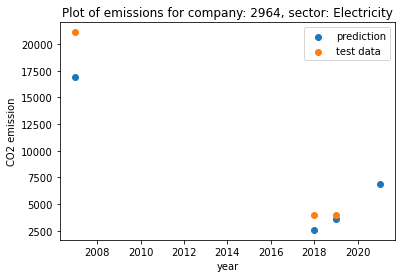

(array([ 3612.17037845,  2577.00573683, 16947.82361436,  6853.3009764 ]), 1989.6667567888896)


In [14]:
#Example using organization id 500. Any organization ID can be filled in here to predict their results for 2021.
#If the organization_id is not valid or no prediction can be made, the function will return:'No prediction possible.'

wanted_org = input("What organization_id would you like to predict for: ")
int_wanted_org = int(wanted_org)
print(int_wanted_org)
print(predict(dict_id2,int_wanted_org))
# print(predict(dict_id2, 500))
# print(predict(dict_id2, 500))

In [ ]:
k_values = [1,2,3,4,5,6,7,8,9,10]
abs_errors = [164407.94, 156111.52, 234852.14, 234719.96, 234719.96, 234456.85, 234325.95, 234195.36, 234065.81, 233936.7]
abs_org = [617722.8808075781,586335.4161847472,883014.6145932323,882516.8669805623,882020.8852844458,881525.9811848517,881032.9784557963,880541.1983632415,880053.3002613973,879567.0774580123]
abs_sect = [268.12541071581046,271.9705322860848,272.6619535985858,272.6629444118977,272.664730471334,272.6665979881113,272.6685182889568,272.6704162392239,272.6724443053568
,272.6746770419094]

plt.plot(k_values, abs_errors)
# plt.plot(k_values, abs_org,'red')
# plt.plot(k_values, abs_sect,'green')
plt.xlabel("k value")
plt.ylabel('mean mean absolute error of all organizations')
plt.title('mean absolute error for different k-order polynomials')
plt.show()

In [ ]:
k_values = [1,2,3,4,5,6,7,8,9,10]
abs_org = [617722.8808075781,586335.4161847472,883014.6145932323,882516.8669805623,882020.8852844458,881525.9811848517,881032.9784557963,880541.1983632415,880053.3002613973,879567.0774580123
          ]
plt.plot(k_values, abs_sect,'green')
plt.xlabel("k value")
plt.ylabel('mean mean absolute error of sector')
plt.title('mean absolute error for different k-order polynomials')
plt.show()

In [ ]:
k_values = [1,2,3,4,5,6,7,8,9,10]
abs_org = [617722.8808075781,586335.4161847472,883014.6145932323,882516.8669805623,882020.8852844458,881525.9811848517,881032.9784557963,880541.1983632415,880053.3002613973,879567.0774580123]
plt.plot(k_values, abs_org,'red')
plt.xlabel("k value")
plt.ylabel('mean mean absolute error grouped by organization')
plt.title('mean absolute error for different k-order polynomials')
plt.show()